# Model: Bathroom classifier
## Classes: bathroom with toilet, without toilet, and not bathroom (other kind of room)

The purpose is to have a model that identifies a room as a bathroom and if so, detect the presence of a toilet bowl to classify the image into one of two categories. \
Such a model could be used, for example, when analyzing images of houses or hotel interiors to automatically determine whether a bathroom includes a toilet. \
I expect the main challenge to be toilets that are partially obstructed, unconventionally shaped toilets and potential confusion between toilets and sinks/ bathtubs. However, I think the model will be able to tell bathrooms from non bathrooms apart relatively easily as no matter the design there are strong features that all bathrooms have like sinks and bathtubs/shower stalls.

In [1]:
from fastai.vision.all import *
path = Path('data')

<u> First let's download our data.</u> \
Using Duck Duck Go search engine we will find images of various interiors, download them using fastai tools and place them into separate folders. 
* Note: this does not build the final dataset, the results still need to be manually filtered so that we're left with the 3 classes folders we want, as the images of bathrooms that were placed into no-toilet/ folder by this download script can still have toilets in them and vice versa. 

In [ ]:
from ddgs import DDGS
import time
from ddgs.exceptions import RatelimitException

# --- Configuration ---
target_count = 100   
pause_time = 5.0 
# ---------------------

# map folder names to search queries
searches = {
    'toilet': 'bathroom with toilet photo',
    'no-toilet': 'bathroom sink and shower only interior',
    'bathroom': 'home bathroom', # for manual filtering into the 2 above
    'not-bathroom': 'house room interior'
}

print("Starting image download process with DuckDuckGo...")

for folder, query in searches.items():
    dest = path/folder
    dest.mkdir(exist_ok=True, parents=True) 
    
    print(f"\nSearching for: '{query}'")

    # 1. search for images:
    try:
        with DDGS() as ddgs:
            results = ddgs.images(
                query=query,    
                max_results=target_count
            )
            urls = [r['image'] for r in results if 'image' in r]
    
    except RatelimitException as e:
        print(f"!!! RATELIMIT HIT for {folder}. Please wait 10 minutes and try again.")
        print(f"Error details: {e}")
        break

    # 2. download the Images
    print(f"Found {len(urls)} URLs. Downloading to {dest}...")
    
    download_images(dest, urls=urls)
    
    print(f"Finished downloading for '{folder}'. Pausing {pause_time}s...")
    time.sleep(pause_time) # pause between searches

print("\n--- All downloads complete! ---")

# --- Verification and Cleaning ---
# find all image files in the data directory
fns = get_image_files(path)
print(f"\nTotal images downloaded: {len(fns)}")

# verify for any corrupt images and unlink (delete) them
failed = verify_images(fns)
print(f"Failed/Corrupt images removed: {len(failed)}")
failed.map(Path.unlink)

Manual filtering was needed here because when asking for a picture of a bathroom most of the time there is also a toilet in the frame. So after running it a couple times and filtering the downloaded data into 3 folders. I had ~110 examples in each folder:

In [69]:
final_data = [
    'toilet',
    'no-toilet',
    'not-bathroom'
]
def num_of_files(data_folder):
    return (data_folder, len([p for p in (path/data_folder).iterdir() if p.is_file()]))
# display map of folder name: num of files
dict(map(num_of_files, final_data))

{'toilet': 108, 'no-toilet': 112, 'not-bathroom': 114}

### Load the data using ImageDataLoaders (abstraction over DataBlock)

In [230]:
dls = ImageDataLoaders.from_folder(
    path,
    valid_pct=0.2,        
    seed=42,
    item_tfms=Resize(300, method='squish'), # 224 is ResNet standard so just a bit larger
    batch_tfms=aug_transforms(mult=1.0)  
)

* Note: the resize method used here is 'squish', other methods like crop and pad, from my tests are less convenient here. Esspecially crop as it can crop out the toilet out of the frame and what was a correctly labeled image before becomes a missleading example for the model. 

Here are some examples from our data:

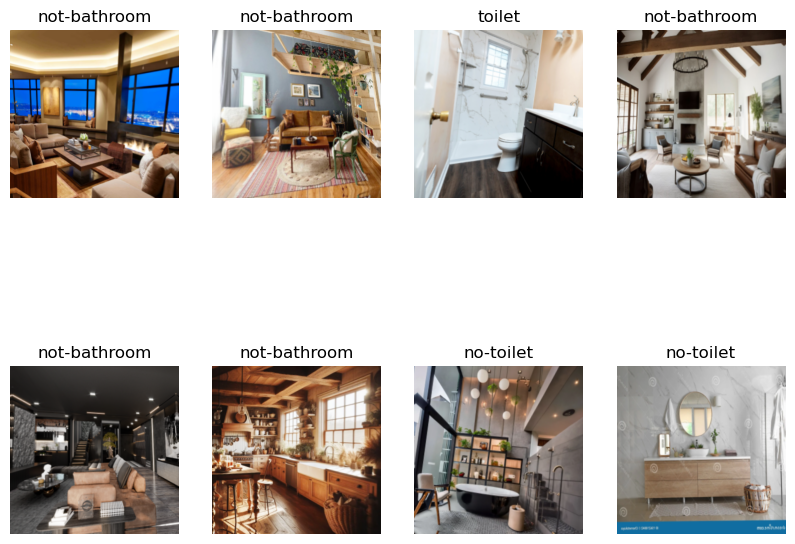

In [173]:
dls.show_batch(max_n=8, figsize=(10,8))

Create an image classification model using a pretrained ResNet34
and track accuracy during training

In [175]:
learn = vision_learner(
    dls,
    resnet34,
    metrics=accuracy
)

### Training
Train using fastai’s fine_tune method, which first trains the newly added layers while keeping the pretrained ones from ResNet frozen, and then gradually unfreezes the entire network to adapt it to the bathroom image classification task.

In [177]:
learn.fine_tune(5)

epoch,train_loss,valid_loss,accuracy,time
0,1.597306,0.739332,0.696970,01:14


epoch,train_loss,valid_loss,accuracy,time
0,1.039462,0.663791,0.712121,01:41
1,0.852280,0.687784,0.757576,01:47
2,0.667965,0.635931,0.772727,01:44
3,0.560071,0.574933,0.787879,01:38
4,0.477564,0.512096,0.833333,01:39


### Evaluation:
Loss graph:

<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

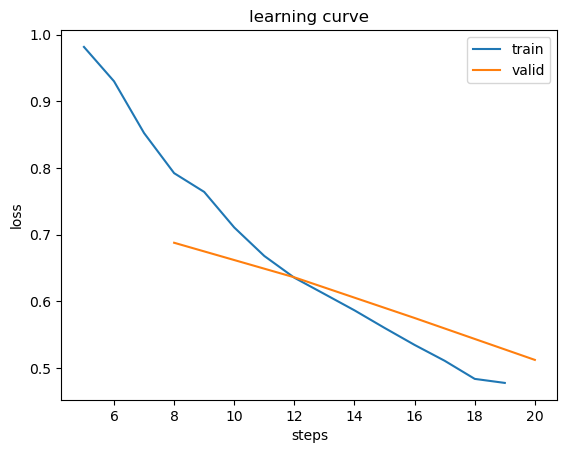

In [182]:
learn.recorder.plot_loss()

Confusion matrix:

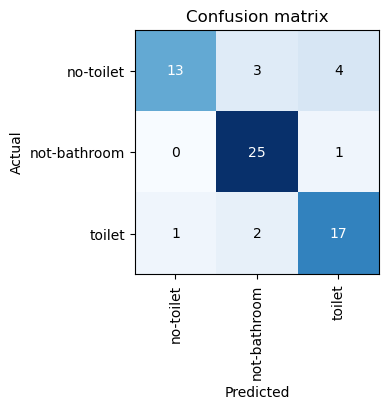

In [185]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(4,4))

We can see that the model sometimes struggles to tell bathooms with no toilet apart from non bathroom rooms as well as having a 'false toilet' problem. Possibly as expected it confuses other objects with toilet bowls. \
Let's examine the top losses, where the model struggled most.

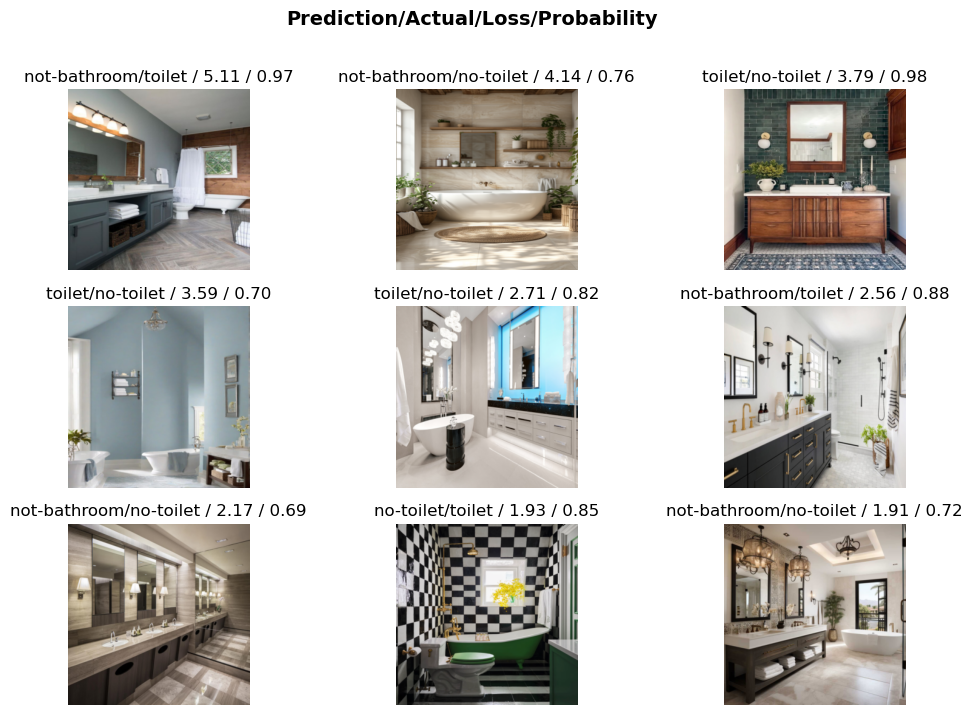

In [186]:
interp.plot_top_losses(9, figsize=(12,8))

We can see that in some images the toilet is obstructed and the model struggles to see it properly. In others the interior of the bathroom is somewhat confusing and unusual so the model classifies it as a regular room. Some cases also seem like the model confused objects in them with toilet bowls, as we expected. \
Here are some more examples of our model's classifications:

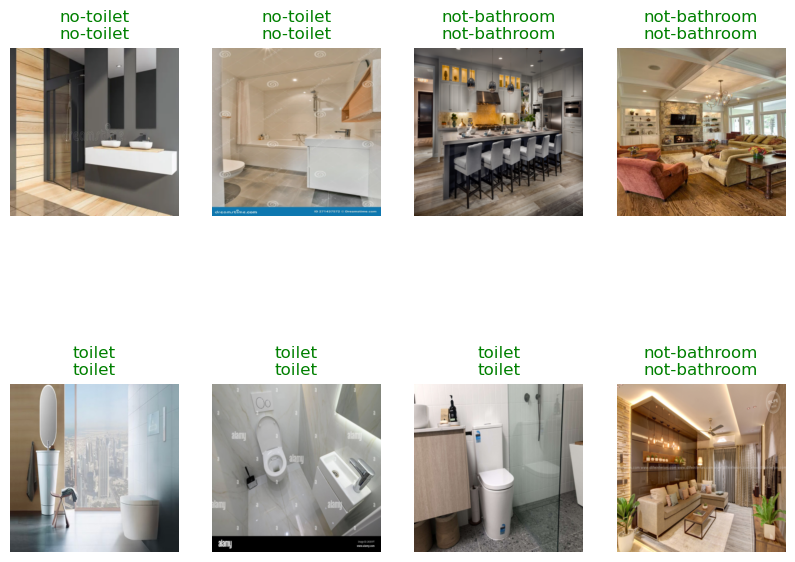

In [207]:
learn.show_results(max_n=8, figsize=(10,8))

### Predictions:
Let's try and classify some images that the model has never seen before.

In [209]:
def predict_image(path):
    img = PILImage.create(path)
    pred, pred_idx, probs = learn.predict(img)
    img.show(title=f"Prediction: {pred} ({probs[pred_idx]:.2f})")

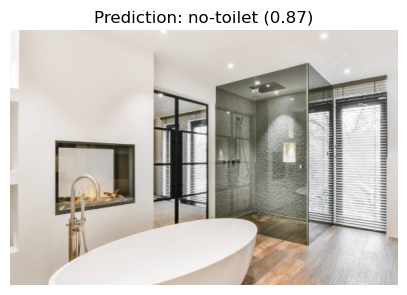

In [211]:
predict_image('predictions/bathroom1.jpg')

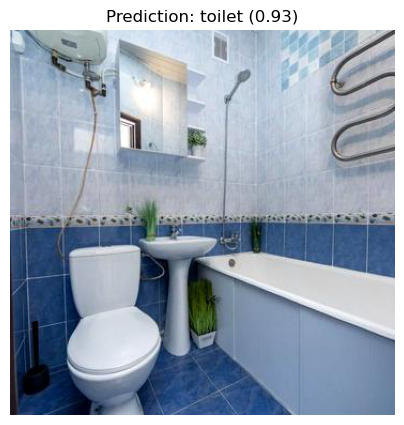

In [213]:
predict_image('predictions/bathroom2.jpg')

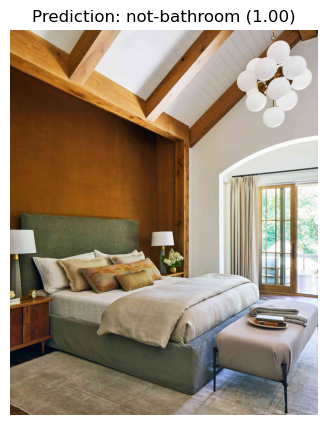

In [215]:
predict_image('predictions/not-bathroom.jpg')

### Summing up
As we can see, and as was expected the model is mostly really good at telling bathrooms apart from non-bathrooms, however on occasion, it struggles with recognizing a toilet in rooms that are bathrooms, or where the toilet is obstructed.  